In [10]:
import os
import sys
import time
import math
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

import torch.optim as optim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
data_statistics = (
    (0.49139968, 0.48215827, 0.44653124),
     (0.24703233, 0.24348505, 0.26158768)
) # Mean, Standard Deviation of CIFAR-10 dataset channels

In [18]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics)
])

In [19]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=False, transform=test_transforms)

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [20]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *data_statistics)
    ax.imshow(make_grid(denorm_images[:64], 8).permute(1, 2, 0))
    break

In [21]:
train_batch_size = 64
test_batch_size = 100

train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, test_batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

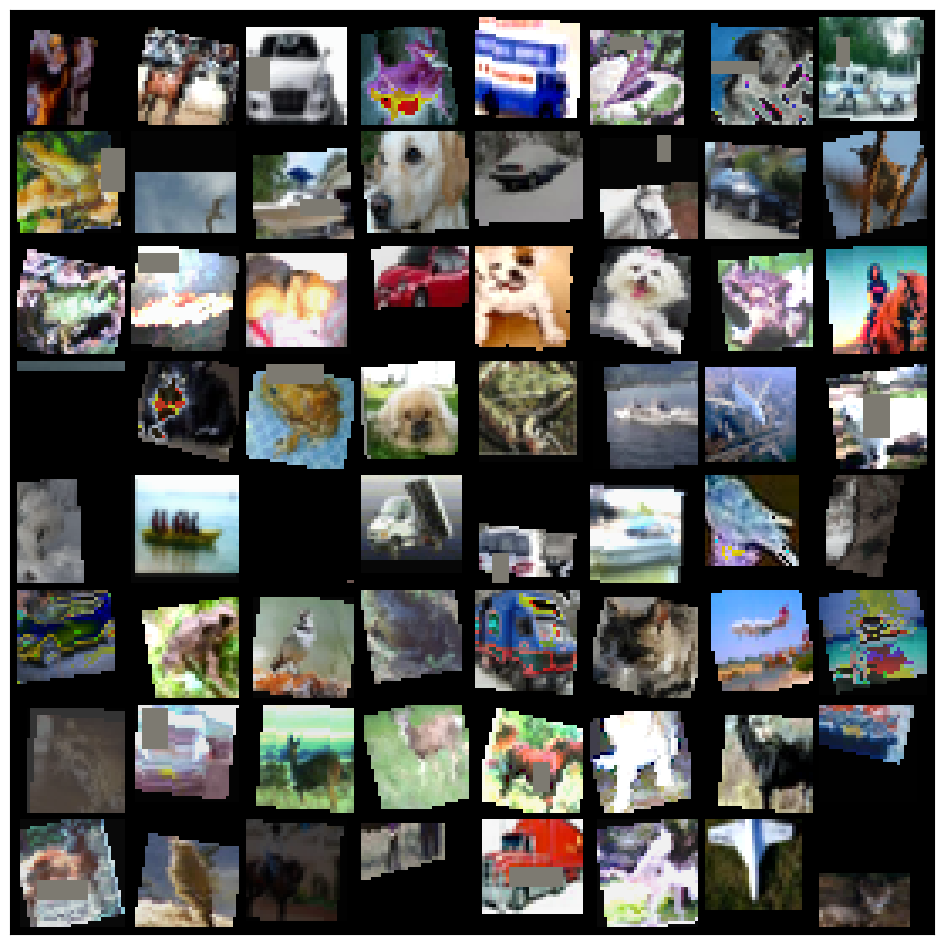

In [22]:
show_batch(train_dl)

In [23]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_default_device()  # NEW CODE: Define device here

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [24]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)

test_dl = DeviceDataLoader(test_dl, device)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class BottleneckBlock(nn.Module):
    expansion = 4  # Bottleneck expands channels by 4x

    def __init__(self, in_planes, planes, stride=1):
        super(BottleneckBlock, self).__init__()
        # 1x1 convolution to reduce channels to 'planes'
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 3x3 convolution with stride (spatial downsampling)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # 1x1 convolution to expand channels to 'planes * expansion'
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # Add SE block here
        self.se = SEBlock(planes * self.expansion)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        # Apply SE block before adding the shortcut
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SEBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(SEBlock, self).__init__()
        # Squeeze operation (global average pooling)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Excitation operation (bottleneck with two FC layers)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_ratio, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Scale
        return x * y.expand_as(x)


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 40  # Initial channel size

        # Initial convolution (modified for CIFAR-10/32x32 input)
        self.conv1 = nn.Conv2d(3, 40, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(40)

        # Layers with Bottleneck blocks
        self.layer1 = self._make_layer(block, 40, layers[0], stride=1)   # 40 -> 40*4=160
        self.layer2 = self._make_layer(block, 80, layers[1], stride=2)   # 80 -> 80*4=320
        self.layer3 = self._make_layer(block, 144, layers[2], stride=2)  # 144 -> 144*4=576
        self.layer4 = self._make_layer(block, 176, layers[3], stride=2)  # 176 -> 176*4=704

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(176 * block.expansion, num_classes)  # 176*4=704

    def _make_layer(self, block, planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  # Update in_planes for next blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def resnet50_light(num_classes=10, dropout_rate=0.5):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=num_classes, dropout_rate=dropout_rate)

if __name__ == "__main__":
    model = resnet50_light(num_classes=10, dropout_rate=0.5)
    print(model)
    summary(model.cuda(), (3, 32, 32))  # Input shape for CIFAR-10

ResNet(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=160, out_features=10, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1

In [26]:
import torch.backends.cudnn as cudnn
device='cuda' if torch.cuda.is_available() else 'cpu'
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [27]:
import torch.optim as optim

r = 0.1

start_epoch = 1
number_of_epochs = 350  # 250 + 100 = 350 total epochs
best_acc = 0

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initial learning rate of 0.2
optimizer = optim.SGD(model.parameters(), lr=0.2,
                      momentum=0.9, weight_decay=5e-4)

# Reduce learning rate to 0.1 after 250 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)


In [28]:
def train(epoch):
  print('\nEpoch: %d' % epoch)
  start_time = time.time()

  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(train_dl):
    # Move inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()



  cur_time = time.time()
  epoch_time = cur_time - start_time
  print(f"Training Time : {format_time(epoch_time)}")

  return train_loss/(batch_idx+1), 100.*correct/total, get_lr(optimizer)

def test(epoch):
  global best_acc
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dl):
      # Move inputs and targets to the same device as the model
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    print('Saving..')
    state = {
        'net': model.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
    torch.save(state, './checkpoint/resnet_34_dropout_best.pth')
    best_acc = acc

  return test_loss/(batch_idx+1), 100.*correct/total

In [29]:
def get_lr(optimizer):
    """Retrieve the current learning rate from the optimizer."""
    for param_group in optimizer.param_groups:
        return param_group['lr']  # Return the learning rate of the first param group

In [32]:
import time

def format_time(seconds):
    """Convert seconds to a readable format (hh:mm:ss)."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [ ]:
train_losses = []
train_accuracies = []
train_lrs = []

test_losses = []
test_accuracies = []

for epoch in range(start_epoch, start_epoch + number_of_epochs):
  epoch_train_loss, epoch_train_accuracy, epoch_lr = train(epoch)
  train_losses.append(epoch_train_loss)
  train_accuracies.append(epoch_train_accuracy)
  train_lrs.append(epoch_lr)

  epoch_test_loss, epoch_test_accuracy = test(epoch)
  test_losses.append(epoch_test_loss)
  test_accuracies.append(epoch_test_accuracy)

  scheduler.step()
  print(f"Learning Rate: {epoch_lr} Train Loss: {epoch_train_loss:.3f} | Train Accuracy: {epoch_train_accuracy:.3f}% | Test Loss: {epoch_test_loss:.3f} | Test Accuracy: {epoch_test_accuracy:.3f}%")


Epoch: 1
Training Time : 00:01:40
Saving..
Learning Rate: 0.2 Train Loss: 1.990 | Train Accuracy: 28.868% | Test Loss: 1.799 | Test Accuracy: 37.860%

Epoch: 2
Training Time : 00:01:47
Learning Rate: 0.2 Train Loss: 1.887 | Train Accuracy: 35.148% | Test Loss: 1.863 | Test Accuracy: 36.010%

Epoch: 3
Training Time : 00:01:41
Saving..
Learning Rate: 0.2 Train Loss: 1.827 | Train Accuracy: 38.612% | Test Loss: 1.800 | Test Accuracy: 40.330%

Epoch: 4
Training Time : 00:01:41
Learning Rate: 0.2 Train Loss: 1.793 | Train Accuracy: 40.250% | Test Loss: 1.999 | Test Accuracy: 38.040%

Epoch: 5
Training Time : 00:01:41
Saving..
Learning Rate: 0.2 Train Loss: 1.774 | Train Accuracy: 41.068% | Test Loss: 1.736 | Test Accuracy: 47.210%

Epoch: 6
Training Time : 00:01:41
Saving..
Learning Rate: 0.2 Train Loss: 1.737 | Train Accuracy: 43.166% | Test Loss: 1.593 | Test Accuracy: 49.560%

Epoch: 7
Training Time : 00:01:41
Saving..
Learning Rate: 0.2 Train Loss: 1.732 | Train Accuracy: 43.582% | Tes

In [ ]:
# At the end of training (after the loop)
torch.save(model.state_dict(), 'final_model.pth')

In [ ]:
from google.colab import files

# Save the model (as you already did)
torch.save(model.state_dict(), 'final_model.pth')

# Download the saved model file
files.download('final_model.pth')

In [ ]:
import pickle
import numpy as np
import torch
def load_custom_test_set(filepath):
    # Open the pickle file and load the data
    with open(filepath, 'rb') as f:
        data = pickle.load(f, encoding='bytes')

    # Extract image data
    images = data[b'data']  # Shape: (10000, 32, 32, 3)

    # Fix Shape: Convert (32, 32, 3) → (3, 32, 32)
    images = np.transpose(images, (0, 3, 1, 2))  # New shape: (10000, 3, 32, 32)

    # Convert data to float32
    images = images.astype(np.float32) / 255.0  # Normalize to [0,1]

    # Convert to a PyTorch tensor
    images = torch.tensor(images, dtype=torch.float32)

    return images

# Load test images from the provided file path.
test_images = load_custom_test_set("/content/cifar_test_nolabel.pkl")
print("Loaded custom test set with shape:", test_images.shape)  # e.g., (10000, 3, 32, 32)

In [ ]:
pkl_mean = [0.513, 0.497, 0.462]
pkl_std = [0.263, 0.260, 0.273]

normalize = transforms.Normalize(mean=pkl_mean, std=pkl_std)

def preprocess_images(images):
    # Loop over each image to apply normalization
    for i in range(images.shape[0]):
        images[i] = normalize(images[i])
    return images

test_images = preprocess_images(test_images)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(test_images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# Load model
import pandas as pd
from google.colab import files
model = resnet50_light(num_classes=10, dropout_rate=0.5)
model.load_state_dict(torch.load('final_model.pth'))
model = model.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)  # Match training configuration

model.eval()

# Generate predictions
all_ids = []
all_preds = []

with torch.no_grad():
    for batch_idx, (images,) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Create IDs (batch_idx * batch_size + index_in_batch)
        batch_ids = [str(batch_idx * 128 + i) for i in range(len(images))]

        all_ids.extend(batch_ids)
        all_preds.extend(preds.cpu().numpy())

# Create and save CSV
submission_df = pd.DataFrame({'ID': all_ids, 'Labels': all_preds})
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')